## Dataset loading and visualization

(100,) (100,)


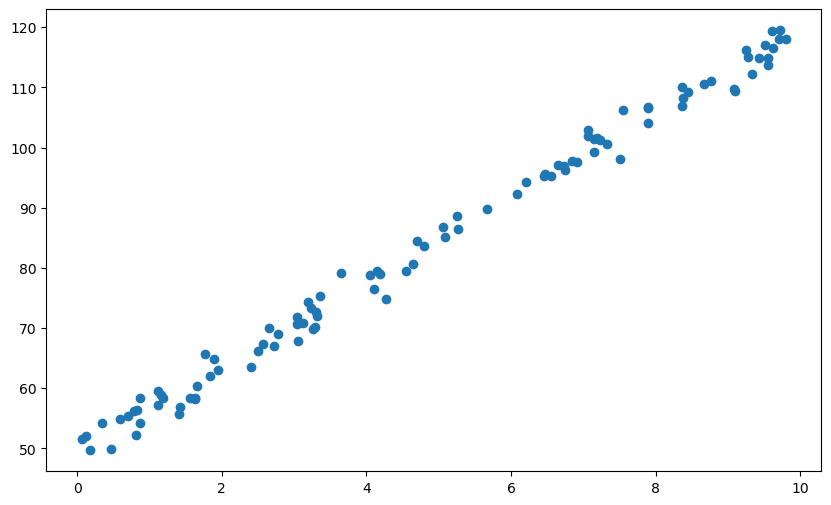

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
max_x = 10

plt.figure(figsize=(10, 6))
dataset = np.load('linear_regression_dataset.npz')
x, y = dataset['x'], dataset['y']
dataset_size = x.shape[0]
print(x.shape, y.shape)

def plot(x, y, slope=None, offset_y=None):
    plt.plot(x, y, 'o') # scatter plot of dataset
    if slope is not None:
        plt.plot([0, max_x], [offset_y, offset_y + max_x * slope]) # straight line defined by slope and offset_y
    plt.show()

plot(x, y)

## Linear regression based on hand derived derivative
Implement the `compute_derivatives` function.

In [ ]:
def compute_derivatives(x, y, slope, offset_y):
    slope_derivative = 0
    offset_y_derivative = 0
    
    # Compute slope derivative and offset derivative
    # ** for each point in the dataset! **
    
    return slope_derivative, offset_y_derivative

def compute_error(x, y, slope, offset_y):
    error = 0
    for i in range(dataset_size):
        error += (offset_y + slope * x[i] - y[i]) ** 2
    error /= dataset_size
    return error

slope = 4 # our inital guess for the slope parameter
offset_y = 1 # our inital guess for the offset parameter
print('plot before training')
plot(x, y, slope, offset_y)
num_steps = 100000
learning_rate = 0.0001
for iteration in range(1, num_steps + 1):
    slope_derivative, offset_y_derivative = compute_derivatives(x, y, slope, offset_y)
    slope = slope - learning_rate * slope_derivative
    offset_y = offset_y - learning_rate * offset_y_derivative
    if iteration in [100, 200, 500, 1000, 5000] or iteration % 10000 == 0:
        print('iter: {}, slope: {}, offset_y: {}, error: {}'.format(iteration, slope, offset_y,
              compute_error(x, y, slope, offset_y)))
    if iteration in [500, 20000, 50000]:
        plot(x, y, slope, offset_y)
print('plot after training')
plot(x, y, slope, offset_y)

## Linear regression based on EDF

Implement the `forward` and `backward` method of the class `L2Loss`.

In [ ]:
import edf

# y shape: (batch size, 1)
# y_hat shape: (batch size, 1)
# output shape: (batch size, 1)
class L2Loss(edf.CompNode):
    def __init__(self, y, y_hat):
        edf.CompNodes.append(self)
        self.y = y
        self.y_hat = y_hat

    def forward(self):
        self.y_hat = ...

    def backward(self):
        # Add gradients to all nodes
        # self.node_name.addgrad()
        self.y.addgrad(......)
        pass

### Definition of EDF's computation graph
Use EDF to assemble a computational graph for linear regression with the "mean" images as input. You will need the `L2Loss` node that you implemented above. The function `train` below expects variables `affine_params`, `x_node`, `y_node` and `loss_node` to be defined.

In [ ]:
f.y_hat = edf.clear_compgraph()
x_node = edf.Input()
y_node = edf.Input()
affine_params = edf.AffineParams(1, 1) # Affine layer with one input and one output
y_hat_node = edf.Affine(affine_params, x_node)
loss_node = L2Loss(y_node, y_hat_node)

In [ ]:
def train(num_steps, x, y, affine_params, x_node, y_node, loss_node):
    affine_params.A.value[0, 0] = 4 # manually overwrite EDF's random initalization to get consistent results
    affine_params.b.value[0] = 1
    x_node.value = x.reshape(-1, 1)
    y_node.value = y.reshape(-1, 1)
    for iteration in range(1, num_steps + 1):
        edf.Forward()
        edf.Backward(loss_node)
        edf.UpdateParameters()
        error = np.sum(loss_node.value) / dataset_size
        slope = affine_params.A.value[0, 0]
        offset_y = affine_params.b.value[0]
        if iteration in [100, 200, 500, 1000, 5000] or iteration % 10000 == 0:
            print('iter: {}, slope: {}, offset_y: {}, error: {}'.format(iteration, slope, offset_y, error))

edf.learning_rate = learning_rate
train(num_steps, x, y, affine_params, x_node, y_node, loss_node)

In [ ]:
plt.figure(figsize=(10, 6))
slope = y_hat_node.w.A.value
offset_y = y_hat_node.w.b.value
plot(x, y, slope.item(), offset_y.item())